### Import Libraries and Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm.notebook import tqdm

### Task 1: Computing Gradients

Let $\phi(x): \mathbb{R} \rightarrow \mathbb{R}$ and its derivative $\phi'(x)$ be
$$ \begin{aligned}
    \phi(x) &= \frac{e^x - e^{-x}}{e^x + e^{-x}}                     && = \tanh(x)  \\
   \phi'(x) &= 1 - \Bigl( \frac{e^x - e^{-x}}{e^x + e^{-x}} \Bigr)^2 && = 1 - \tanh^2(x)  \\
   \end{aligned} $$
   \**Later on, when we choose different functions for $\phi$, we will simply redefine $\phi$ and $\phi'$.*

In [2]:
def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - np.tanh(x)**2

More generally, the expression $f_{\mathbf{w}}(\mathbf{x})$ in (2) can be written as:
$$ f_{\mathbf{w}}(\mathbf{x}) = \sum_{i = 1}^k \alpha_i \phi (a_i^Tx + b_i) + \beta \qquad \forall x \in \mathbb{R}^n $$
where $\phi(x): \mathbb{R} \rightarrow \mathbb{R}$ is an arbitrary activation function. 

The set of parameters $\mathbf{w} \in \mathbb{R}^p$ is defined as
$$\mathbf{w} = \{ (\alpha_1, a_{1n} \cdots a_{1n}, b_1) \cdots (\alpha_k, a_{kn} \cdots a_{kn}, b_k) \beta\}$$
where $p = (n + 1)k + k + 1$. 

The individual parameters $\alpha_i \in \mathbb{R}$, $\beta \in \mathbb{R}$, $a_i \in \mathbb{R}^n$, $b_i \in \mathbb{R}$. In (2), we have $n = k = 3$ and $p = 16$ and
$$\mathbf{w} = \{\alpha_1, a_{11}, a_{12}, a_{13}, b_1, \alpha_2, a_{21}, a_{22}, a_{23}, b_2, \alpha_3, a_{31}, a_{32}, a_{33}, b_3, \beta\}$$

Let the gradient $\nabla_{\mathbf{w}}f_{\mathbf{w}}(\mathbf{x})$ be defined as
$$ \nabla_{\mathbf{w}}f_{\mathbf{w}}(\mathbf{x}) = 
\biggl[
\frac{\delta f_{\mathbf{w}}(\mathbf{x})}{\delta w_1} \quad
\frac{\delta f_{\mathbf{w}}(\mathbf{x})}{\delta w_2} \quad
\cdots
\quad
\frac{\delta f_{\mathbf{w}}(\mathbf{x})}{\delta w_p}
\biggr]^T
$$
where
$$
\frac{\delta f_{\mathbf{w}}(\mathbf{x})}{\delta w_m} =
\begin{cases}
    \phi(a_i^Tx + b_i)            & \text{if } w_m = \alpha_i \text{ for some } i \\
    1                             & \text{if } w_m = \beta \\
    \alpha_i\phi'(a_i^Tx + b_i)x_j & \text{if } w_m = a_{ij} \text{ for some } (i,j) \\
    \alpha_i\phi'(a_i^Tx + b_i)    & \text{if } w_m = b_i \text{ for some } i \\
\end{cases}
$$

In [3]:
'''
w (vector): array of parameters with length p
x (vector): input vector of length 1 x n
k (scalar): layers in the neural network
'''
def gradient(w, x, k=3, phi=tanh, phi_prime=tanh_prime):
    n = len(x) # 3 in this case

    # k rows each with structure [alpha_k a_k1 ... a_1n b_k]
    w_truncated = w[:15]
    W = w_truncated.reshape(k, n + 2) # reshape k x (n + 2) 
    gradient = np.zeros_like(W)

    # for every layer calculate
    for i in range(k):
        alpha_phi_prime = W[i][0] * phi_prime(W[i][1:-1] @ x)
        
        # case of a_i
        gradient[i][0] = phi(W[i][1:-1] @ x)
    
        # case of a_ij
        for j in range(n):
            gradient[i][j + 1] = alpha_phi_prime * x[j]
    
        # case of b_i
        gradient[i][-1] = alpha_phi_prime

    # appending 1 for case of beta
    return np.append(gradient.flatten(), 1) # Shape 1 x p (1 x 16)

In [4]:
def init_w_rand(seed=42, lower=0, upper=1):
    np.random.seed(seed)
    return np.random.uniform(low=lower, high=upper, size=16)

### Task 2: Computing Derivative Matrix

The Jacobian matrix of a vector-valued function of several variables is the matrix of all of its first-order partial derivatives. Given the dataset $\{ (x_n, y_n)\}_{n=1}^N$, let $r_n(w) = f_{\mathbf{w}}(x_n) - y_n$ and define $r: \mathbb{R}^p \rightarrow \mathbb{R}^N$ such that:
$$r(w) = \bigl[ r_1(w) \quad r_w(w) \quad \cdots \quad r_N(w) \bigr]^T$$

then the Jacobian matrix $\operatorname{Dr}(\mathbf{w}) \in \mathbb{R}^{n \times p}$ is given by
$$
\operatorname{Dr}(\mathbf{w}) = 
\begin{bmatrix}
\frac{\delta r_1}{\delta w_1} & \frac{\delta r_1}{\delta w_2} & \cdots & \frac{\delta r_1}{\delta w_p} \\
\frac{\delta r_2}{\delta w_1} & \frac{\delta r_2}{\delta w_2} & \cdots & \frac{\delta r_2}{\delta w_p} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\delta r_N}{\delta w_1} & \frac{\delta r_N}{\delta w_2} & \cdots & \frac{\delta r_N}{\delta w_p}
\end{bmatrix} =
\begin{bmatrix}
\frac{\delta f_{\mathbf{w}}(x_1)}{\delta w_1} & \frac{\delta f_{\mathbf{w}}(x_1)}{\delta w_2} & \cdots & \frac{\delta f_{\mathbf{w}}(x_1)}{\delta w_p} \\
\frac{\delta f_{\mathbf{w}}(x_2)}{\delta w_1} & \frac{\delta f_{\mathbf{w}}(x_2)}{\delta w_2} & \cdots & \frac{\delta f_{\mathbf{w}}(x_2)}{\delta w_p} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\delta f_{\mathbf{w}}(x_N)}{\delta w_1} & \frac{\delta f_{\mathbf{w}}(x_N)}{\delta w_2} & \cdots & \frac{\delta f_{\mathbf{w}}(x_N)}{\delta w_p}
\end{bmatrix}
$$

In [5]:
# X: N samples each with 3 points
def jacobian(init_w, x_train, phi=tanh, phi_prime=tanh_prime):
    N = len(x_train)
    jacobian = np.zeros((N, 16))

    for i in range(N):
        jacobian[i, :] = gradient(init_w, x_train[i], 3, phi, phi_prime)

    return jacobian

### Task 3: Levenberg-Marquardt Algorithm

Let's define a handful of helper functions:

In [6]:
# Evaluates g(x) = x_1 * x_2 + x_3
def g(x):
    return x[0] * x[1] + x[2]

# Returns inverse of given matrix
def inv(matrix):
    return np.linalg.inv(matrix)

# L2 Norm Squared
def l2_norm_squared(w):
    return w @ w.T

# Plots iteration versus loss using matplotlib
def plot_loss(loss, title='Iteration Versus Loss'):
    # Plotting index versus value
    plt.plot(loss)

    # Adding labels and title
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(title)

    # Display the plot
    plt.show()

# Computes N predictions 
def eval_w(w_k, x_train, phi=tanh): # WORKS FINE
    result = []
    for x in x_train:
        x_bias = np.append(x, 1)

        alpha_1 = w_k[0]
        alpha_2 = w_k[5]
        alpha_3 = w_k[10]

        a_1 = [w_k[1], w_k[2], w_k[3], w_k[4]]
        a_2 = [w_k[6], w_k[7], w_k[8], w_k[9]]
        a_3 = [w_k[11], w_k[12], w_k[13], w_k[14]]

        beta = w_k[15]

        result.append(alpha_1 * phi(a_1 @ x_bias) +
                      alpha_2 * phi(a_2 @ x_bias) +
                      alpha_3 * phi(a_3 @ x_bias) +
                      beta)

    return np.array(result)

# Evalutes N residuals
def residual(w_k, x_train, y_train, phi=tanh): # WORKS FINE
    return eval_w(w_k, x_train, phi) - y_train

The following is a simple method to generate $N$ random points $\mathbf{x}^{(n)}=\left[x_1^{(n)}, x_2^{(n)}, x_3^{(n)}\right]^T \in \mathbb{R}^3$ such that
$$ \max \left\{\left|x_1^{(n)}\right|,\left|x_2^{(n)}\right|,\left|x_3^{(n)}\right|\right\} \leqslant \Gamma$$
for all $n = 1, 2, \ldots, N$ and their corresponding $\mathbf{y}^{(n)}=x_1^{(n)}x_2^{(n)} + x_3^{(n)}$ values. By default, we have $N = 500$ and $\Gamma = 1$ (convenient for generating the training set).

In [7]:
'''
Parameters:
- N: number of random points
- seed: random seed
- gamma: generate elements in x that are between -gamma and gamma

Return:
- x: shape (500, 3) matrix
- y: shape (500,  ) matrix
'''
def generate_pairs(N=500, seed=42, gamma=1, epsilon=0):
    np.random.seed(seed)
    x = np.random.uniform(-gamma, gamma, size=(N, 3))
    e = np.random.uniform(-epsilon, epsilon, N)
    y = x[:, 0] * x[:, 1] + x[:, 2] + e[:]
    return x, y

#### Levenberg-Marquardt Psuedocode and Notes

Initialization. Pick an initial point $w^{(0)}$, an initial trust parameter $\lambda^{(0)}$, $0 < \alpha < 1$, and  $\beta > 1$. 

For $k = 0, 1, \ldots, k^{\text{max}}$:

1) First-order approximation of $r$ at $w^{(k)}$: $\hat{r}(w;w^{(k)}) = r(w^{(k)}) + Dr(w^{(k)})(w - w^{(k)})$.
2) Solve the linear least squares problem: $w^* = \operatorname{arg min} \parallel \hat{r}(w; w^{(k)}) \parallel_2^2 + \lambda^{(k)} \parallel w - w^{(k)} \parallel_2^2$
3) Check and update:
    - If $\parallel r(w^{*})) \parallel_2^2 < \parallel r(w^{(k)})) \parallel_2^2$, set $\lambda^{(k + 1)} = \alpha \lambda^{(k)}$ and $w^{(k + 1)} = w^*$.
    - Otherwise, set $\lambda^{(k)} = \beta \lambda^{(k)}$ and $w^{(k + 1)} = w^{(k)}$

Note that we can rewrite
$$ \begin{aligned}
w^* &= \operatorname{arg min} \left\| \hat{r}(w; w^{(k)}) \right\|_2^2 + \lambda^{(k)} \left\| w - w^{(k)} \right\|_2^2 \\
    &= \operatorname{arg min} \left\| Dr(w^{(k)})w - (Dr(w^{(k)})w^{(k)} - r(w^{(k)})) \right\|_2^2 + \left\| \sqrt{\lambda^{(k)}} w - \sqrt{\lambda^{(k)}} w^{(k)} \right\|_2^2 \\
    &= \operatorname{arg min} \left\| 
    \begin{bmatrix}
    Dr(w^{(k)}) \\
    \sqrt{\lambda^{(k)}} I \\
    \end{bmatrix}w
    -
    \begin{bmatrix}
    Dr(w^{(k)})w^{(k)} - r(w^{(k)}) \\
    \sqrt{\lambda^{(k)}} w^{(k)} \\
    \end{bmatrix}
    \right\|^2_2
\end{aligned} $$
We know the minimizer to be the psuedoinverse. Therefore, we can write:
$$ \begin{aligned}
w^* &= \left(
    \begin{bmatrix}
    Dr(w^{(k)}) \quad
    \sqrt{\lambda^{(k)}} I 
    \end{bmatrix}
    \begin{bmatrix}
    Dr(w^{(k)}) \\
    \sqrt{\lambda^{(k)}} I \\
    \end{bmatrix} 
    \right)^{-1} 
    \begin{bmatrix}
    Dr(w^{(k)}) \quad
    \sqrt{\lambda^{(k)}} I 
    \end{bmatrix} 
    \begin{bmatrix}
    Dr(w^{(k)})w^{(k)} - r(w^{(k)}) \\
    \sqrt{\lambda^{(k)}} w^{(k)} \\
    \end{bmatrix}\\
    &= \left( Dr(w^{(k)})^TDr(w^{(k)}) + \lambda^{(k)}I \right)^{-1} \left( Dr(w^{(k)})^TDr(w^{(k)})w^{(k)} - Dr(w^{(k)})^TDr(w^{(k)}) + \lambda^{(k)}w^{(k)} \right) \\
    &= \left( Dr(w^{(k)})^TDr(w^{(k)}) + \lambda^{(k)}I \right)^{-1} \left( Dr(w^{(k)})^TDr(w^{(k)}) + \lambda^{(k)}I \right)w^{(k)} - Dr(w^{(k)})^Tr(w^{(k)}) \\
    &= w^{(k)} - \left( Dr(w^{(k)})^TDr(w^{(k)}) + \lambda^{(k)}I \right)^{-1} Dr(w^{(k)})^T r(w^{(k)})
\end{aligned} $$

#### Levenberg Marquardt Code

In [55]:
'''
Levenberg-Marquardt Algorithm:

Parameters:
- train_x: shape (500, 3) matrix 
- train_y: shape (500,  ) matrix
- init_lambda: default 10^-5
- init_w: inital parameters
- alpha: param
- beta: param

Returns:
- w_k: the final p parameters produces by the algorithm
- loss: an array with indices = iteration and value = loss at that iteration
'''
def lm(x, y, w_init, k_max, alpha, beta, init_lambda=10**-5, phi=tanh, phi_prime=tanh_prime):
    w_k = w_init
    l_k = init_lambda
    loss = [0] * k_max
    I = np.eye(16)
    
    for k in tqdm(range(k_max)):
        D = jacobian(w_k, x, phi, phi_prime)
        DT = D.T
        r = residual(w_k, x, y, phi)

        # (16, ) - ( (16, 500) @ (500, 16) )^-1 @ ((16, 500) @ (500, ))
        # (16, ) - (16, 16)^-1 @ (16, )
        # (16, ) - (16, )
        w_star = w_k - inv(DT @ D + l_k * I) @ (DT @ r)

        loss[k] = l2_norm_squared(residual(w_star, x, y, phi)) / 500

        l2_norm_squared_w_star = l2_norm_squared(w_star)
        l2_norm_squared_w_k = l2_norm_squared(w_k)
        
        # Check and update
        if l2_norm_squared_w_star < l2_norm_squared_w_k:
            # print("----------------------")
            l_k = alpha * l_k
            w_k = w_star
            l2_norm_squared_w_k = l2_norm_squared_w_star
        else:
            l_k = beta * l_k
            # print(f"lambda at {k}: {l_k}")
        
        if l2_norm_squared_w_k < 0.01:
            break

    return w_k, loss

### Task 3ab): Training/Testing loss using $\phi = \operatorname{tanh}(x)$

#### a) Various Parameter Initializations

In [56]:
x_train, y_train = generate_pairs()

In [64]:
# Random value between zero and one
w_1 = init_w_rand(42, 0, 1)
w_star_1, loss_1 = lm(x=x_train, y=y_train, w_init=w_1, k_max=250, alpha=.8, beta=2)

  0%|          | 0/250 [00:00<?, ?it/s]

In [65]:
# Random value between -1 and 1
w_2 = init_w_rand(42, -1, 1)
w_star_2, loss_2 = lm(x=x_train, y=y_train, w_init=w_2, k_max=250, alpha=.8, beta=2)

  0%|          | 0/250 [00:00<?, ?it/s]

In [66]:
# All ones
w_3 = np.ones(16)
w_star_3, loss_3 = lm(x=x_train, y=y_train, w_init=w_3, k_max=250, alpha=.8, beta=2)

  0%|          | 0/250 [00:00<?, ?it/s]

In [67]:
# All negative ones
w_4 = -np.ones(16)
w_star_4, loss_4 = lm(x=x_train, y=y_train, w_init=w_4, k_max=250, alpha=.8, beta=2)

  0%|          | 0/250 [00:00<?, ?it/s]

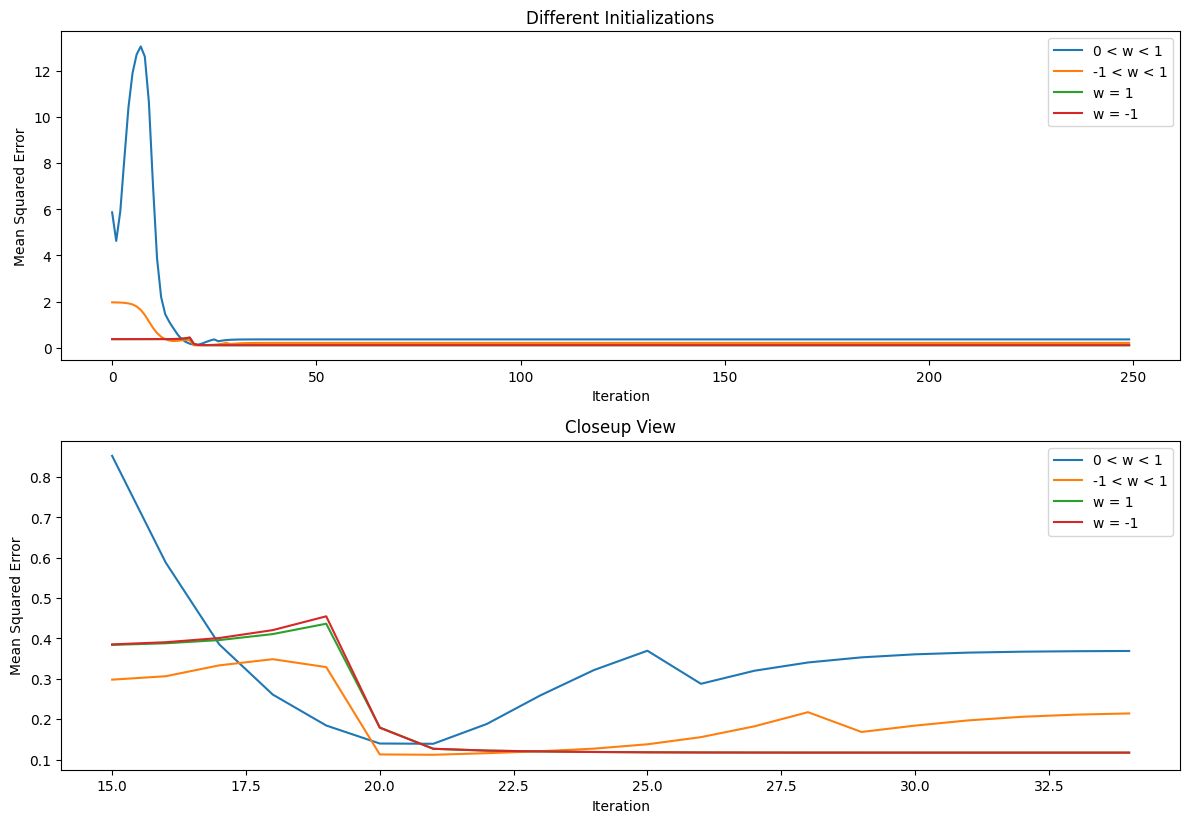

In [77]:
# Plotting results
plt.figure(figsize=(12, 12))

# Plot 1: Entire range
plt.subplot(3, 1, 1)
plt.plot(loss_1, label='0 < w < 1')
plt.plot(loss_2, label='-1 < w < 1')
plt.plot(loss_3, label='w = 1')
plt.plot(loss_4, label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('Different Initializations')
plt.legend()

# Plot 2: Range from index 50 to the end
plt.subplot(3, 1, 2)
plt.plot(range(15, 35), loss_1[15:35], label='0 < w < 1')
plt.plot(range(15, 35), loss_2[15:35], label='-1 < w < 1')
plt.plot(range(15, 35), loss_3[15:35], label='w = 1')
plt.plot(range(15, 35), loss_4[15:35], label='w = -1')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('Closeup View')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()

#### b) Various Parameter Initializations, $\lambda$, $\Gamma_T$

In [15]:
eval = eval_w(w_star_2, x_train)

print(f"Point: {x_train[2]}")
print(f"Predicted: {eval[2]}")
print(f"Actual: {g(x_train[2])}")

Point: [-0.88383278  0.73235229  0.20223002]
Predicted: -0.02694425232118655
Actual: -0.4450469351177031


In [16]:
def test(w_star, x_test, y_test):
    r = residual(w_star, x_test, y_test)
    return l2_norm_squared(r) / 100

In [17]:
x_test, y_test = generate_pairs(100, 43, 1)

In [18]:
print(f"Training MSE: {loss_4[-1]}")
testing_error = test(w_star_4, x_test, y_test)
print(f"Testing MSE: {testing_error}")

Training MSE: 0.11704227041093906
Testing MSE: 0.13497594498732413


### Task 3ci): Training/Testing loss with different w, $\lambda$, $\Gamma$ using $\phi = \operatorname{sigmoid}(x)$

In [63]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

#### a) Various Parameter Initializations

#### ai) Testing on $N = 500$ training points

#### b) Testing on $N_T = 100$ testing points with various $\lambda$, $\Gamma_T$

In [20]:
x_train_g01, y_train_g01 = generate_pairs(N=500, seed=42, gamma=0.1, epsilon=0)

In [48]:
w_ones = np.ones(16)
w_star_21, loss_21 = lm(x=x_train_g01, y=y_train_g01, w_init=w_ones, k_max=250, alpha=.9, beta=1.1, 
                        init_lambda=1, phi=relu, phi_prime=relu_prime)

  0%|          | 0/250 [00:00<?, ?it/s]

In [49]:
w_star_22, loss_22 = lm(x=x_train, y=y_train, w_init=w_ones, k_max=250, alpha=.9, beta=1.1, 
                        init_lambda=10**-5, phi=relu, phi_prime=relu_prime)

  0%|          | 0/250 [00:00<?, ?it/s]

In [50]:
w_star_23, loss_23 = lm(x=x_train, y=y_train, w_init=w_ones, k_max=250, alpha=.9, beta=1.1, 
                        init_lambda=10**-10, phi=relu, phi_prime=relu_prime)

  0%|          | 0/250 [00:00<?, ?it/s]

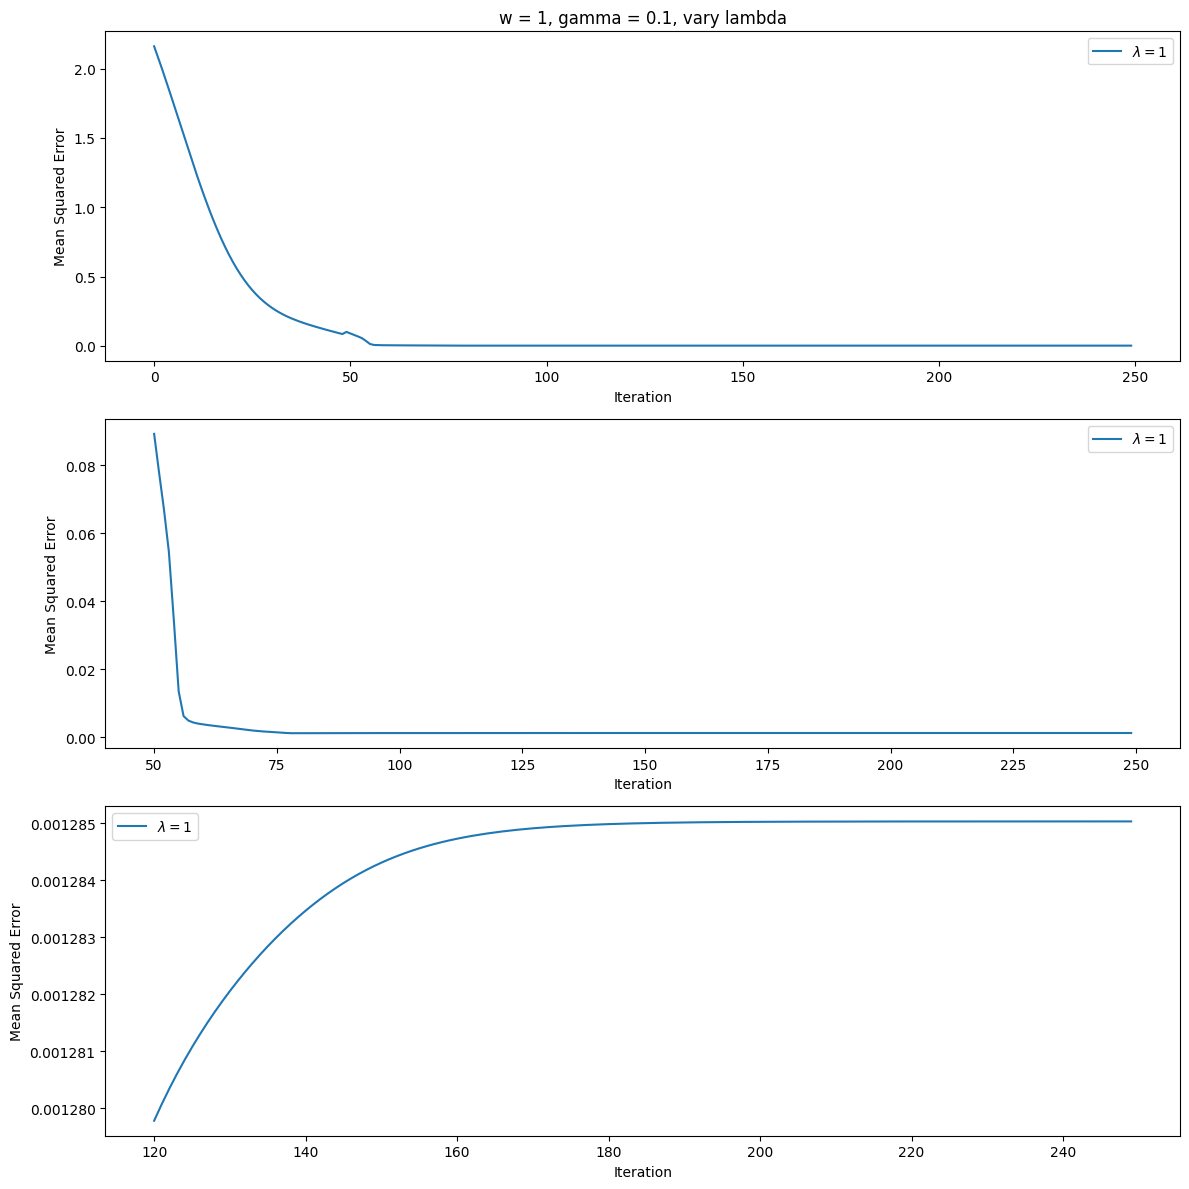

In [54]:
# Plotting results
plt.figure(figsize=(12, 12))

# Plot 1: Entire range
plt.subplot(3, 1, 1)
plt.plot(loss_21, label='$\lambda = 1$')
plt.plot(loss_22, label='$\lambda = 10^{-5}$')
plt.plot(loss_23, label='$\lambda = 10^{-10}$')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('w = 1, gamma = 0.1, vary lambda')
plt.legend()

# Plot 2: Range from index 50 to the end
plt.subplot(3, 1, 2)
plt.plot(range(50, len(loss_21)), loss_21[50:], label='$\lambda = 1$')
plt.plot(range(50, len(loss_22)), loss_22[50:], label='$\lambda = 10^{-5}$')
plt.plot(range(50, len(loss_23)), loss_23[50:], label='$\lambda = 10^{-10}$')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.legend()

# Plot 3: Range from index 100 to the end
plt.subplot(3, 1, 3)
plt.plot(range(120, len(loss_21)), loss_21[120:], label='$\lambda = 1$')
plt.plot(range(120, len(loss_22)), loss_22[120:], label='$\lambda = 10^{-5}$')
plt.plot(range(120, len(loss_23)), loss_23[120:], label='$\lambda = 10^{-10}$')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()

In [33]:
x_train_g10, y_train_g10 = generate_pairs(N=500, seed=42, gamma=10, epsilon=0)

In [43]:
w_ones = np.ones(16)
w_star_24, loss_24 = lm(x=x_train_g10, y=y_train_g10, w_init=w_ones, k_max=500, alpha=.9, beta=1.1, 
                        init_lambda=1, phi=sigmoid, phi_prime=sigmoid_prime)

  0%|          | 0/500 [00:00<?, ?it/s]

In [44]:
w_star_25, loss_25 = lm(x=x_train_g10, y=y_train_g10, w_init=w_ones, k_max=500, alpha=.9, beta=1.1, 
                        init_lambda=10**-5, phi=sigmoid, phi_prime=sigmoid_prime)

  0%|          | 0/500 [00:00<?, ?it/s]

In [45]:
w_star_26, loss_26 = lm(x=x_train_g10, y=y_train_g10, w_init=w_ones, k_max=500, alpha=.9, beta=1.1, 
                        init_lambda=10**-10, phi=sigmoid, phi_prime=sigmoid_prime)

  0%|          | 0/500 [00:00<?, ?it/s]

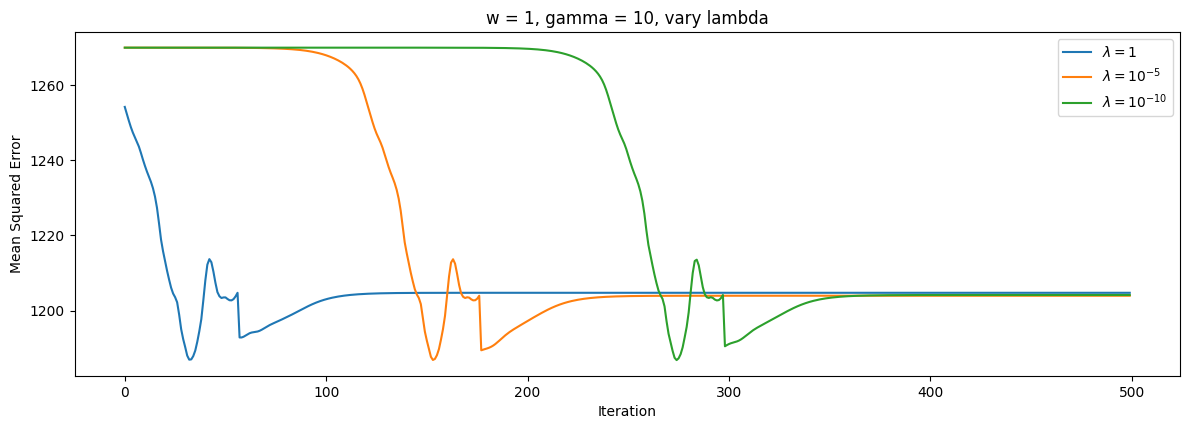

In [46]:
# Plotting results
plt.figure(figsize=(12, 12))

# Plot 1: Entire range
plt.subplot(3, 1, 1)
plt.plot(loss_24, label='$\lambda = 1$')
plt.plot(loss_25, label='$\lambda = 10^{-5}$')
plt.plot(loss_26, label='$\lambda = 10^{-10}$')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('w = 1, gamma = 10, vary lambda')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()

In [25]:
eval = eval_w(w_star_21, x_train, sigmoid)

In [27]:
print(f"Point: {x_train[2]}")
print(f"Predicted: {eval[2]}")
print(f"Actual: {g(x_train[2])}")

Point: [-0.88383278  0.73235229  0.20223002]
Predicted: 0.29207731690397426
Actual: -0.4450469351177031


### Task 3cii): Training/Testing loss with different w, $\lambda$, $\Gamma$ using $\phi = \operatorname{relu}(x)$

In [ ]:
def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    return np.where(x > 0, 1, 0)

#### a) Training with various parameter initializations 

#### ai) Testing on $N = 500$ training points

#### b) Testing on $N_T = 100$ testing points with various $\lambda$, $\Gamma_T$

### Task 3d): Training/Testing loss with different w, $\lambda$, $\Gamma$ with added noise

#### a) Training with various parameter initializations 

#### ai) Testing on $N = 500$ training points

#### b) Testing on $N_T = 100$ testing points with various $\lambda$, $\Gamma_T$

In [28]:
x_train_noise, y_train_noise = generate_pairs(N=500, seed=42, gamma=1, epsilon=1)

In [29]:
w_train = init_w_rand()

In [30]:
result_params_noise, loss_noise = lm(x_train_noise, y_train_noise, w_train, 400, .9, 1.1, 10**-5, sigmoid, sigmoid_prime)

  0%|          | 0/400 [00:00<?, ?it/s]

/var/folders/sk/m_1xv2y17xx96_8k07vtlgz80000gn/T/ipykernel_29353/1684531285.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


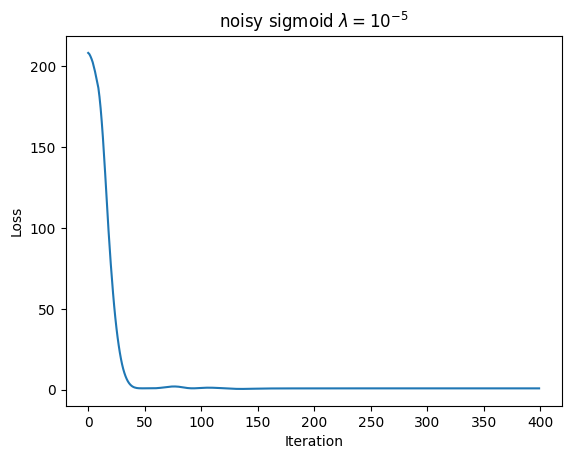

In [31]:
plot_loss(loss_noise, 'noisy sigmoid $\lambda = 10^{-5}$')